Import necessary libraries:

In [1]:
import numpy as np
import jax
import jax.lib
import jax.numpy as jnp
from jax import grad, jit
from jax.nn import initializers
import matplotlib.pyplot as plt
from functools import partial
import time
import copy
from collections import deque
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

We now want the functions needed for training, which use jax architecture.

In [2]:
def init_network_params(layer_dims, key):
    keys = jax.random.split(key, len(layer_dims) - 1)
    params = []
    for i, (in_dim, out_dim) in enumerate(zip(layer_dims[:-1], layer_dims[1:])):
        W = initializers.glorot_normal()(keys[i], (in_dim, out_dim))
        b = initializers.zeros(keys[i], (out_dim,))
        params.append((W, b))
    return params

@jit
def jax_relu(x):
    return jnp.maximum(0, x)

def jax_softmax(x, axis=-1):
    x_max = jnp.max(x, axis=axis, keepdims=True)
    exp_x = jnp.exp(x - x_max)
    return exp_x / jnp.sum(exp_x, axis=axis, keepdims=True)

def jax_forward(params, x):
    """Returns logits for classification."""
    activation = x
    for i, (W, b) in enumerate(params[:-1]):
        outputs = jnp.dot(activation, W) + b
        activation = jax_relu(outputs)
    final_W, final_b = params[-1]
    logits = jnp.dot(activation, final_W) + final_b
    return logits

def jax_update_params(params, grads, lr):
    return [(W - lr * dW, b - lr * db) for (W, b), (dW, db) in zip(params, grads)]

@jit
def jax_compute_crossentropy_loss(params, x_batch, y_batch_one_hot):
    """Computes Cross-Entropy loss for classification."""
    logits = jax_forward(params, x_batch)
    log_probs = jax.nn.log_softmax(logits, axis=-1)
    return -jnp.sum(y_batch_one_hot.astype(jnp.float32) * log_probs) / x_batch.shape[0]

jax_loss_grad_fn = jit(grad(jax_compute_crossentropy_loss, argnums=0))

def jax_predict_proba(params, x):
    return jax_softmax(jax_forward(params, x))

def compute_accuracy_jax(params, x, y_one_hot):
    """Computes accuracy for classification."""
    preds_proba = jax_predict_proba(params, x)
    return jnp.mean(jnp.argmax(preds_proba, axis=1) == jnp.argmax(y_one_hot, axis=1))

Flatten and unflatten parameters, get shape and type of unflattened parameters:

In [3]:
def flatten_params(params_list):
    flat_params_leaves, treedef = jax.tree_util.tree_flatten(params_list)
    flat_params_leaves = [jnp.asarray(leaf) for leaf in flat_params_leaves]
    return jnp.concatenate([p.ravel() for p in flat_params_leaves]), treedef

def unflatten_params(flat_params_vec, treedef, shapes_and_dtypes_meta):
    leaves = []
    current_pos = 0
    for shape, dtype in shapes_and_dtypes_meta:
        num_elements = np.prod(shape, dtype=int)
        leaves.append(jnp.asarray(flat_params_vec[current_pos: current_pos + num_elements], dtype=dtype).reshape(shape))
        current_pos += num_elements
    return jax.tree_util.tree_unflatten(treedef, leaves)

def get_shapes_and_dtypes(params_list):
    flat_params_meta, _ = jax.tree_util.tree_flatten(params_list)
    return [(p.shape, p.dtype) for p in flat_params_meta]

Helper function to compute parameter difference norm:

In [4]:
def compute_params_diff_norm(params1, params2):
    """Computes the Frobenius norm of the difference between two parameter lists."""
    diff_norms_sq = [
        jnp.sum((w1 - w2)**2) + jnp.sum((b1 - b2)**2)
        for (w1, b1), (w2, b2) in zip(params1, params2)
    ]
    return jnp.sqrt(jnp.sum(jnp.array(diff_norms_sq)))

Forward unflattened parameters:

In [5]:
def single_sample_forward_flat_params(flat_params_vec, single_x_input, treedef, shapes_and_dtypes_meta):
    unflattened_params_list = unflatten_params(flat_params_vec, treedef, shapes_and_dtypes_meta)
    return jax_forward(unflattened_params_list, single_x_input.reshape(1, -1))[0]

One-hot encode labels:

In [6]:
def one_hot(y, num_classes=10):
    y_int = np.asarray(y, dtype=int)
    return np.eye(num_classes)[y_int.reshape(-1)]

Run SGD training:

In [7]:
def run_sgd_epochs(params_initial, X_train_sgd, Y_train_onehot_sgd, X_val_full, Y_val_onehot_full,
                   start_epoch_idx, num_epochs_to_run, # start_epoch_idx is 0-based
                   batch_size, lr_sgd, key_sgd_loop, phase_label="SGD"):
    print(f"\n--- Starting {phase_label} Training Phase (Epochs {start_epoch_idx + 1} to {start_epoch_idx + num_epochs_to_run}) ---")
    params = params_initial # Start from provided parameters
    N_train_sgd = X_train_sgd.shape[0]
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    sgd_phase_start_time = time.time()
    current_batch_size = min(batch_size, N_train_sgd)

    for epoch_offset in range(num_epochs_to_run):
        actual_epoch_num_display = start_epoch_idx + epoch_offset + 1 # For printing (1-based)

        key_sgd_loop, subkey_perm = jax.random.split(key_sgd_loop)
        indices = jax.random.permutation(subkey_perm, N_train_sgd)
        
        # --- Mini-batch update loop ---
        for i in range(0, N_train_sgd, current_batch_size):
            X_batch = X_train_sgd[indices[i:i + current_batch_size]]
            Y_batch = Y_train_onehot_sgd[indices[i:i + current_batch_size]]
            grads = jax_loss_grad_fn(params, X_batch, Y_batch)
            params = jax_update_params(params, grads, lr_sgd)
            
        # --- Full-dataset metric logging (end of epoch) ---
        train_loss = float(jax_compute_crossentropy_loss(params, X_train_sgd, Y_train_onehot_sgd))
        train_acc = float(compute_accuracy_jax(params, X_train_sgd, Y_train_onehot_sgd))
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        val_loss = float(jax_compute_crossentropy_loss(params, X_val_full, Y_val_onehot_full))
        val_acc = float(compute_accuracy_jax(params, X_val_full, Y_val_onehot_full))
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"{phase_label} Epoch {actual_epoch_num_display} - Train L: {train_loss:.4f}, A: {train_acc*100:.2f}% | Val L: {val_loss:.4f}, A: {val_acc*100:.2f}%")

    sgd_phase_time = time.time() - sgd_phase_start_time
    print(f"{phase_label} phase ({num_epochs_to_run} epochs) took {sgd_phase_time:.2f} seconds.")
    return params, history, sgd_phase_time

Run SGD phase with monitoring for the switch condition:

In [8]:
def run_sgd_monitoring_switch(
    params_initial, X_train_sgd, Y_train_onehot_sgd, X_val_full, Y_val_onehot_full,
    max_sgd_epochs, batch_size, lr_sgd, key_sgd_loop,
    switch_config,
    X_ntk_monitor_subset, num_classes
):
    print(f"\n--- Starting SGD Phase (Monitoring for Switch using '{switch_config['method']}') ---")
    params = params_initial
    N_train_sgd = X_train_sgd.shape[0]
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    sgd_phase_start_time = time.time()
    current_batch_size = min(batch_size, N_train_sgd)
    
    # --- Switch condition specific setup ---
    method = switch_config['method']
    if method == 'param_norm':
        k = switch_config.get('param_norm_window', 3)
        param_history = deque(maxlen=k + 1)
        param_history.append(copy.deepcopy(params))
        
    elif method == 'ntk_norm':
        k = switch_config.get('ntk_norm_window', 3)
        ntk_total_diff_history = deque(maxlen=k + 1)
        
        _, treedef = flatten_params(params)
        shapes_meta = get_shapes_and_dtypes(params)
        partial_apply_fn = partial(single_sample_forward_flat_params, treedef=treedef, shapes_and_dtypes_meta=shapes_meta)
        jac_fn_single = jax.jacrev(partial_apply_fn, argnums=0)
        J_vmap_fn = jit(jax.vmap(lambda p, x: jac_fn_single(p, x), in_axes=(None, 0), out_axes=0))
        params_flat_initial, _ = flatten_params(params_initial)
        J_initial = J_vmap_fn(params_flat_initial, X_ntk_monitor_subset)
        K_initial = compute_empirical_ntk_k0(J_initial, num_classes)
        ntk_total_diff_history.append(0.0)
        
    epoch_at_switch = max_sgd_epochs

    for epoch in range(max_sgd_epochs):
        actual_epoch_num_display = epoch + 1
        epoch_start_time = time.time()
        key_sgd_loop, subkey_perm = jax.random.split(key_sgd_loop)
        indices = jax.random.permutation(subkey_perm, N_train_sgd)
        
        for i in range(0, N_train_sgd, current_batch_size):
            X_batch = X_train_sgd[indices[i:i + current_batch_size]]
            Y_batch = Y_train_onehot_sgd[indices[i:i + current_batch_size]]
            grads = jax_loss_grad_fn(params, X_batch, Y_batch)
            params = jax_update_params(params, grads, lr_sgd)
            
        # Log metrics
        train_loss = float(jax_compute_crossentropy_loss(params, X_train_sgd, Y_train_onehot_sgd))
        train_acc = float(compute_accuracy_jax(params, X_train_sgd, Y_train_onehot_sgd))
        val_loss = float(jax_compute_crossentropy_loss(params, X_val_full, Y_val_onehot_full))
        val_acc = float(compute_accuracy_jax(params, X_val_full, Y_val_onehot_full))
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"SGD (Monitoring) Epoch {actual_epoch_num_display} - Train L: {train_loss:.4f}, A: {train_acc*100:.2f}% | Val L: {val_loss:.4f}, A: {val_acc*100:.2f}%", end='')
        
        # --- Check switch condition ---
        switch_now = False
        diff_norm = np.nan
        
        if method == 'fixed_epoch':
            if actual_epoch_num_display >= switch_config['fixed_switch_epoch']:
                switch_now = True
        elif method == 'param_norm':
            k = switch_config.get('param_norm_window', 3)
            param_history.append(copy.deepcopy(params))
            if len(param_history) == k + 1:
                diff_norm = compute_params_diff_norm(param_history[-1], param_history[0])
                print(f" | Param diff norm (k={k}) = {diff_norm:.6f}", end='')
                if diff_norm < switch_config['param_norm_threshold']:
                    switch_now = True
        
        elif method == 'ntk_norm':
            k = switch_config.get('ntk_norm_window', 3)
            params_flat_current, _ = flatten_params(params)
            J_current = J_vmap_fn(params_flat_current, X_ntk_monitor_subset)
            K_current = compute_empirical_ntk_k0(J_current, num_classes)
            ntk_diff_total = float(jnp.linalg.norm(K_current - K_initial, 'fro'))
            ntk_total_diff_history.append(ntk_diff_total)
            
            if len(ntk_total_diff_history) == k + 1:
                diff_norm = abs(ntk_total_diff_history[-1] - ntk_total_diff_history[0])
                print(f" | NTK stability (k={k}) = {diff_norm:.4f}", end='')
                if diff_norm < switch_config['ntk_norm_threshold']:
                    switch_now = True

        print(f" (took {time.time() - epoch_start_time:.2f}s)")
        if switch_now:
            epoch_at_switch = actual_epoch_num_display
            print(f">>> Switching condition '{method}' met at epoch {epoch_at_switch} over a {k}-epoch window. <<<")
            break
            
    if epoch == max_sgd_epochs - 1 and not switch_now:
        epoch_at_switch = max_sgd_epochs
        print(f">>> Max SGD epochs ({max_sgd_epochs}) reached without meeting switch condition. This run will be flagged. <<<")
    
    sgd_phase_time = time.time() - sgd_phase_start_time
    print(f"SGD monitoring phase ({epoch_at_switch} epochs) took {sgd_phase_time:.2f} seconds.")
    
    final_history = {k: v[:epoch_at_switch] for k, v in history.items()}
    return params, final_history, sgd_phase_time, epoch_at_switch

In [9]:
def run_sgd_scouting(
    params_initial, X_train_sgd, Y_train_onehot_sgd, X_val_full, Y_val_onehot_full,
    scouting_epochs, batch_size, lr_sgd, key_sgd_loop,
    switch_method, # 'param_norm' or 'ntk_norm'
    X_ntk_monitor_subset, num_classes,
    param_norm_window, ntk_norm_window
):
    print(f"\n--- Starting SGD Scouting Run for {scouting_epochs} Epochs (Method: {switch_method}) ---")
    params = params_initial
    N_train_sgd = X_train_sgd.shape[0]
    history = {'val_loss': [], 'val_acc': [], 'norm_diff': []}
    scouting_start_time = time.time()
    current_batch_size = min(batch_size, N_train_sgd)

    # --- Monitoring setup based on the chosen method ---
    if switch_method == 'param_norm':
        k = param_norm_window
        param_history = deque(maxlen=k + 1)
        param_history.append(copy.deepcopy(params))

    elif switch_method == 'ntk_norm':
        k = ntk_norm_window
        ntk_total_diff_history = deque(maxlen=k + 1)
        
        _, treedef = flatten_params(params)
        shapes_meta = get_shapes_and_dtypes(params)
        partial_apply_fn = partial(single_sample_forward_flat_params, treedef=treedef, shapes_and_dtypes_meta=shapes_meta)
        jac_fn_single = jax.jacrev(partial_apply_fn, argnums=0)
        J_vmap_fn = jit(jax.vmap(lambda p, x: jac_fn_single(p, x), in_axes=(None, 0), out_axes=0))
        params_flat_initial, _ = flatten_params(params_initial)
        J_initial = J_vmap_fn(params_flat_initial, X_ntk_monitor_subset)
        K_initial = compute_empirical_ntk_k0(J_initial, num_classes)
        ntk_total_diff_history.append(0.0)
    
    for epoch in range(scouting_epochs):
        key_sgd_loop, subkey_perm = jax.random.split(key_sgd_loop)
        indices = jax.random.permutation(subkey_perm, N_train_sgd)
        
        for i in range(0, N_train_sgd, current_batch_size):
            X_batch = X_train_sgd[indices[i:i + current_batch_size]]
            Y_batch = Y_train_onehot_sgd[indices[i:i + current_batch_size]]
            grads = jax_loss_grad_fn(params, X_batch, Y_batch)
            params = jax_update_params(params, grads, lr_sgd)

        # Log performance metrics
        history['val_loss'].append(float(jax_compute_crossentropy_loss(params, X_val_full, Y_val_onehot_full)))
        val_acc = float(compute_accuracy_jax(params, X_val_full, Y_val_onehot_full))
        history['val_acc'].append(val_acc)
        
        norm_diff = np.nan
        # --- Unified calculation logic ---
        if switch_method == 'param_norm':
            k = param_norm_window
            param_history.append(copy.deepcopy(params))
            if len(param_history) == k + 1:
                 norm_diff = compute_params_diff_norm(param_history[-1], param_history[0])

        elif switch_method == 'ntk_norm':
            k = ntk_norm_window
            params_flat_current, _ = flatten_params(params)
            J_current = J_vmap_fn(params_flat_current, X_ntk_monitor_subset)
            K_current = compute_empirical_ntk_k0(J_current, num_classes)
            ntk_diff_total = float(jnp.linalg.norm(K_current - K_initial, 'fro'))
            
            ntk_total_diff_history.append(ntk_diff_total)
            if len(ntk_total_diff_history) == k + 1:
                norm_diff = abs(ntk_total_diff_history[-1] - ntk_total_diff_history[0])
        
        history['norm_diff'].append(float(norm_diff))
        
        print(f"Scouting Epoch {epoch + 1}/{scouting_epochs} - Val Acc: {val_acc*100:.2f}% | Norm Diff (k={k}): {norm_diff:.4f}")

    print(f"Scouting run took {time.time() - scouting_start_time:.2f} seconds.")
    return history

Run NTK 1 phase:

In [10]:
def run_ntk1_phase(params_sgd, X_train_ntk, Y_train_onehot_ntk, X_val_full, Y_val_onehot_full,
                   ntk_epochs, batch_size, lr_ntk, key_ntk_loop):
    print("\n--- Starting NTK 1 Phase ---")
    N_train_ntk = X_train_ntk.shape[0]
    
    theta_0_params_unflat = params_sgd
    theta_0_flat, treedef_0 = flatten_params(theta_0_params_unflat)
    shapes_meta_0 = get_shapes_and_dtypes(theta_0_params_unflat)
    theta_k_flat = jnp.copy(theta_0_flat)

    partial_apply_fn = partial(single_sample_forward_flat_params, treedef=treedef_0, shapes_and_dtypes_meta=shapes_meta_0)
    jac_fn_single_sample = jax.jacrev(partial_apply_fn, argnums=0)
    J_at_theta0_single_sample = jit(lambda single_x: jac_fn_single_sample(theta_0_flat, single_x))
    J_batch_at_theta0_vmap = jit(jax.vmap(J_at_theta0_single_sample, in_axes=(0), out_axes=0))
    predict_batch_theta_k_vmap = jit(
        jax.vmap(partial(single_sample_forward_flat_params, treedef=treedef_0, shapes_and_dtypes_meta=shapes_meta_0),
                 in_axes=(None, 0), out_axes=0))

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    ntk1_start_time = time.time()

    for ntk_iter in range(ntk_epochs):
        key_ntk_loop, subkey_perm = jax.random.split(key_ntk_loop)
        indices = jax.random.permutation(subkey_perm, N_train_ntk)
        total_param_update_contrib = jnp.zeros_like(theta_k_flat)
        for i in range(0, N_train_ntk, batch_size):
            X_batch = X_train_ntk[indices[i:i + batch_size]]
            Y_batch_onehot = Y_train_onehot_ntk[indices[i:i + batch_size]]
            J_b_at_theta0 = J_batch_at_theta0_vmap(X_batch)
            logits_b_at_thetak = predict_batch_theta_k_vmap(theta_k_flat, X_batch)
            pred_probas_b_at_thetak = jax_softmax(logits_b_at_thetak)
            Error_batch = pred_probas_b_at_thetak - Y_batch_onehot
            batch_contrib = jnp.einsum('bcp,bc->p', J_b_at_theta0, Error_batch)
            total_param_update_contrib += batch_contrib

        effective_lr_ntk = (2.0 * lr_ntk) / N_train_ntk
        theta_k_flat -= effective_lr_ntk * total_param_update_contrib

        current_params_unflat = unflatten_params(theta_k_flat, treedef_0, shapes_meta_0)
        train_loss = float(jax_compute_crossentropy_loss(current_params_unflat, X_train_ntk, Y_train_onehot_ntk))
        train_acc = float(compute_accuracy_jax(current_params_unflat, X_train_ntk, Y_train_onehot_ntk))
        val_loss = float(jax_compute_crossentropy_loss(current_params_unflat, X_val_full, Y_val_onehot_full))
        val_acc = float(compute_accuracy_jax(current_params_unflat, X_val_full, Y_val_onehot_full))
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        print(f"NTK 1 Iter {ntk_iter + 1}/{ntk_epochs} - Train (full) L: {train_loss:.4f}, A: {train_acc*100:.2f}% | Val (full) L: {val_loss:.4f}, A: {val_acc*100:.2f}%")

    ntk1_time = time.time() - ntk1_start_time
    print(f"NTK 1 phase ({ntk_epochs} iterations) took {ntk1_time:.2f} seconds.")
    final_params_ntk1 = unflatten_params(theta_k_flat, treedef_0, shapes_meta_0)
    return final_params_ntk1, history, ntk1_time

Function to help compute matrix exponential and compute NTK:

In [27]:
def matrix_exp_taylor(A, order=5):
    """Taylor expansion for matrix exponential: I + A + A^2/2! + ..."""
    N = A.shape[0]
    if A.shape[0] != A.shape[1]:
        raise ValueError("Matrix must be square for exponential.")

    result = jnp.eye(N, dtype=A.dtype)
    A_power_k = jnp.eye(N, dtype=A.dtype)
    factorial_k = 1.0

    for k in range(1, order + 1):
        A_power_k = jnp.dot(A_power_k, A)
        factorial_k *= k
        result += A_power_k / factorial_k
    return result

USE_JAX_EXPM = True # Set to False to use Taylor expansion

def compute_matrix_exp(A, taylor_order=5):
    if USE_JAX_EXPM:
        try:
            return jax.scipy.linalg.expm(A)
        except Exception as e:
            print(f"jax.scipy.linalg.expm failed: {e}. Falling back to Taylor expansion.")
            return matrix_exp_taylor(A, order=taylor_order)
    else:
        return matrix_exp_taylor(A, order=taylor_order)

@partial(jit, static_argnames=['num_classes_for_k0'])
def compute_empirical_ntk_k0(J_all_at_theta0, num_classes_for_k0):
    """Computes the empirical NTK for a multi-class output."""
    K0 = jnp.einsum('acp,bcp->ab', J_all_at_theta0, J_all_at_theta0)
    return K0

Run NTK 2 phase:

In [12]:
def run_ntk2_phase(params_sgd, X_train_ntk, Y_train_onehot_ntk, X_val_full, Y_val_onehot_full, sgd_epochs,
                   ntk_epochs, lr_ntk, taylor_order_ntk2):
    print("\n--- Starting NTK 2 Phase ---")
    N_train_ntk = X_train_ntk.shape[0]
    num_classes = Y_train_onehot_ntk.shape[1]

    theta_0_params_unflat = params_sgd
    theta_0_flat, treedef_0 = flatten_params(theta_0_params_unflat)
    shapes_meta_0 = get_shapes_and_dtypes(theta_0_params_unflat)
    theta_k_flat = jnp.copy(theta_0_flat)

    # --- Precompute items related to ?_0 ---
    print("NTK2: Computing J(X_train_ntk, Theta_0) and K_0...")
    partial_apply_fn_theta0 = partial(single_sample_forward_flat_params, treedef=treedef_0, shapes_and_dtypes_meta=shapes_meta_0)
    jac_fn_single_sample_theta0 = jax.jacrev(partial_apply_fn_theta0, argnums=0)
    J_at_theta0_single_sample = jit(lambda single_x: jac_fn_single_sample_theta0(theta_0_flat, single_x))
    J_all_at_theta0_vmap = jit(jax.vmap(J_at_theta0_single_sample, in_axes=(0), out_axes=0))
    J_all_at_theta0 = J_all_at_theta0_vmap(X_train_ntk) # (N, C, P)

    K0 = compute_empirical_ntk_k0(J_all_at_theta0, num_classes) # (N, N)

    predict_batch_theta0_vmap = jit(jax.vmap(partial(single_sample_forward_flat_params, treedef=treedef_0, shapes_and_dtypes_meta=shapes_meta_0),
                                             in_axes=(None, 0), out_axes=0))
    logits_all_at_theta0 = predict_batch_theta0_vmap(theta_0_flat, X_train_ntk)
    pred_probas_all_at_theta0 = jax_softmax(logits_all_at_theta0)
    Error_all_at_theta0 = pred_probas_all_at_theta0 - Y_train_onehot_ntk # (N, C)
    print("NTK2: J(X_train_ntk, Theta_0), K_0, and Error_0 computed.")

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    ntk2_start_time = time.time()

    for k in range(sgd_epochs + 1, sgd_epochs + ntk_epochs + 1):
        matrix_in_exp = -(2/N_train_ntk) * K0 * (k - 3)
        exp_term_matrix = compute_matrix_exp(matrix_in_exp, taylor_order_ntk2) # (N, N)
        damped_error_contribution_k = jnp.dot(exp_term_matrix, Error_all_at_theta0) # (N,N) @ (N,C) -> (N,C)
        total_param_update_contrib = jnp.einsum('ncp,nc->p', J_all_at_theta0, damped_error_contribution_k)

        theta_k_flat -= lr_ntk * total_param_update_contrib

        current_params_unflat = unflatten_params(theta_k_flat, treedef_0, shapes_meta_0)
        train_loss = float(jax_compute_crossentropy_loss(current_params_unflat, X_train_ntk, Y_train_onehot_ntk))
        train_acc = float(compute_accuracy_jax(current_params_unflat, X_train_ntk, Y_train_onehot_ntk))
        val_loss = float(jax_compute_crossentropy_loss(current_params_unflat, X_val_full, Y_val_onehot_full))
        val_acc = float(compute_accuracy_jax(current_params_unflat, X_val_full, Y_val_onehot_full))
        
        history['train_loss'].append(train_loss); history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss); history['val_acc'].append(val_acc)
        print(f"NTK 2 (Matrix Exp) Iter {k}/{ntk_epochs+sgd_epochs} - Train L: {train_loss:.4f}, A: {train_acc*100:.2f}% | Val L: {val_loss:.4f}, A: {val_acc*100:.2f}%")

    ntk2_time = time.time() - ntk2_start_time
    print(f"NTK 2 phase (Matrix Exp, {ntk_epochs} iterations) took {ntk2_time:.2f} seconds.")
    final_params_ntk2 = unflatten_params(theta_k_flat, treedef_0, shapes_meta_0)
    return final_params_ntk2, history, ntk2_time

Run NTK 3 phase:

In [13]:
def run_ntk3_phase(params_sgd, X_train_ntk, Y_train_onehot_ntk, X_val_full, Y_val_onehot_full,
                   lr_ntk, lambda_ntk3_reg, T_factor_ntk3, taylor_order_ntk3):
    print(f"\n--- Starting NTK 3 Phase (Matrix Exp, T_factor={T_factor_ntk3}) ---")
    N_train_ntk = X_train_ntk.shape[0]
    num_classes = Y_train_onehot_ntk.shape[1]
    
    theta_0_params_unflat = params_sgd
    theta_0_flat, treedef_0 = flatten_params(theta_0_params_unflat)
    shapes_meta_0 = get_shapes_and_dtypes(theta_0_params_unflat)

    print("NTK3: Computing J(X_train_ntk, Theta_0), K_0, and Error_0...")
    partial_apply_fn_theta0 = partial(single_sample_forward_flat_params, treedef=treedef_0, shapes_and_dtypes_meta=shapes_meta_0)
    jac_fn_single_sample_theta0 = jax.jacrev(partial_apply_fn_theta0, argnums=0)
    J_at_theta0_single_sample = jit(lambda single_x: jac_fn_single_sample_theta0(theta_0_flat, single_x))
    J_all_at_theta0_vmap = jit(jax.vmap(J_at_theta0_single_sample, in_axes=(0), out_axes=0))

    ntk3_start_time = time.time()
    J_all_at_theta0 = J_all_at_theta0_vmap(X_train_ntk) # (N, C, P)

    predict_batch_theta0_vmap = jit(jax.vmap(partial(single_sample_forward_flat_params, treedef=treedef_0, shapes_and_dtypes_meta=shapes_meta_0),
                                             in_axes=(None, 0), out_axes=0))
    logits_all_at_theta0 = predict_batch_theta0_vmap(theta_0_flat, X_train_ntk)
    pred_probas_all_at_theta0 = jax_softmax(logits_all_at_theta0)
    Error_all_at_theta0 = pred_probas_all_at_theta0 - Y_train_onehot_ntk

    K0 = compute_empirical_ntk_k0(J_all_at_theta0, num_classes)
    print("NTK3: J, K0, Error0 computed.")

    matrix_B_in_exp = -(2/N_train_ntk) * K0 * (T_factor_ntk3 - 3)
    exp_B_matrix = compute_matrix_exp(matrix_B_in_exp, taylor_order_ntk3)
    
    Identity_N = jnp.eye(N_train_ntk, dtype=K0.dtype)
    Factor_Matrix = Identity_N - exp_B_matrix

    print(f"NTK3: Solving for K0_dagger_times_Factor_times_Error (lambda_reg={lambda_ntk3_reg})...")
    Target_for_solve = jnp.dot(Factor_Matrix, Error_all_at_theta0)
    try:
        K0_dagger_Factor_Error = jnp.linalg.solve(K0 + lambda_ntk3_reg * jnp.eye(N_train_ntk), Target_for_solve)
    except Exception as e:
        print(f"NTK3: jnp.linalg.solve failed: {e}. Attempting with pseudo-inverse.")
        K0_reg_pinv = K0 + lambda_ntk3_reg * jnp.eye(N_train_ntk)
        K0_dagger_Factor_Error = jnp.dot(jnp.linalg.pinv(K0_reg_pinv, rcond=1e-6), Target_for_solve)
    print("NTK3: Solved.")

    param_update_direction = jnp.einsum('ncp,nc->p', J_all_at_theta0, K0_dagger_Factor_Error)
    theta_T_flat = theta_0_flat - param_update_direction
    
    final_params_ntk3 = unflatten_params(theta_T_flat, treedef_0, shapes_meta_0)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    train_loss = float(jax_compute_crossentropy_loss(final_params_ntk3, X_train_ntk, Y_train_onehot_ntk))
    train_acc = float(compute_accuracy_jax(final_params_ntk3, X_train_ntk, Y_train_onehot_ntk))
    val_loss = float(jax_compute_crossentropy_loss(final_params_ntk3, X_val_full, Y_val_onehot_full))
    val_acc = float(compute_accuracy_jax(final_params_ntk3, X_val_full, Y_val_onehot_full))

    history['train_loss'].append(train_loss); history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss); history['val_acc'].append(val_acc)

    ntk3_total_time = time.time() - ntk3_start_time
    print(f"NTK 3 (One-Shot) - Train (full) L: {train_loss:.4f}, A: {train_acc*100:.2f}% | Val (full) L: {val_loss:.4f}, A: {val_acc*100:.2f}%")
    print(f"NTK 3 phase took {ntk3_total_time:.2f} seconds.")
    return final_params_ntk3, history, ntk3_total_time

Evaluate the results on the test set:

In [14]:
def evaluate_on_test_jax(params, X_test, Y_test_onehot):
    if params is None:
        print("\nTest Evaluation - No parameters provided.")
        return np.nan, np.nan
    
    test_loss = float(jax_compute_crossentropy_loss(params, X_test, Y_test_onehot))
    test_acc = float(compute_accuracy_jax(params, X_test, Y_test_onehot))

    print(f"\nTest Set Evaluation - Loss: {test_loss:.4f}, Accuracy: {test_acc * 100:.2f}%")
    return test_loss, test_acc

Average histories:

In [15]:
def aggregate_histories(list_of_histories, metric_keys=['train_loss', 'val_loss', 'train_acc', 'val_acc']):
    if not list_of_histories:
        return {key: {'mean': [], 'std': []} for key in metric_keys}

    aggregated = {}
    for key in metric_keys:
        all_series = [h[key] for h in list_of_histories if key in h and h[key]]
        if not all_series:
            aggregated[key] = {'mean': [], 'std': []}
            continue

        max_len = max(len(s) for s in all_series)
        padded_series = []
        for s in all_series:
            padding = [np.nan] * (max_len - len(s))
            padded_series.append(s + padding)

        stacked_series = np.array(padded_series)

        means = []
        stds = []
        for i in range(max_len):
            column = stacked_series[:, i]
            valid_values = column[~np.isnan(column)]
            if valid_values.size > 0:
                means.append(np.mean(valid_values))
                stds.append(np.std(valid_values) if valid_values.size > 1 else 0.0)
            else:
                means.append(np.nan)
                stds.append(np.nan)

        aggregated[key] = {
            'mean': means,
            'std': stds
        }
    return aggregated

def aggregate_scalar_metrics(list_of_scalar_metrics):
    if not list_of_scalar_metrics:
        return {'mean': np.nan, 'std': np.nan}
    metrics_array = np.array([m for m in list_of_scalar_metrics if m is not np.nan])
    if metrics_array.size == 0:
        return {'mean': np.nan, 'std': np.nan}
    return {
        'mean': np.nanmean(metrics_array),
        'std': np.nanstd(metrics_array)
    }

Fetch and normalize the dataset (here you can choose your own dataset):

In [16]:
dataset_name = "Fashion-MNIST"
num_classes = 10

print(f"Fetching {dataset_name} data...")
data = fetch_openml(dataset_name, version=1, as_frame=False, parser='auto', cache=True)

X_np_all = data.data.astype(np.float32) / 255.0
Y_labels_np_all = data.target.astype(np.int32)

print("Data fetched and normalized.")

Fetching Fashion-MNIST data...
Data fetched and normalized.


Prepare the data - divide it into train/val/test sets, convert to numpy arrays, one-hot encode outputs:

In [17]:
X_train_val_np, X_test_np, Y_labels_train_val_np, Y_labels_test_np = train_test_split(
        X_np_all, Y_labels_np_all, test_size=0.2, random_state=42, stratify=Y_labels_np_all)
X_train_np_full, X_val_np_full, Y_labels_train_np_full, Y_labels_val_np_full = train_test_split(
    X_train_val_np, Y_labels_train_val_np, test_size=0.25, random_state=42, stratify=Y_labels_train_val_np)

# Full datasets for SGD and final validation/testing
X_train_full = jnp.array(X_train_np_full)
Y_labels_train_full = Y_labels_train_np_full
X_val_full = jnp.array(X_val_np_full)
Y_labels_val_full = Y_labels_val_np_full
X_test_full = jnp.array(X_test_np)
Y_labels_test_full = Y_labels_test_np

Y_train_onehot_full = jnp.array(one_hot(Y_labels_train_full, num_classes))
Y_val_onehot_full = jnp.array(one_hot(Y_labels_val_full, num_classes))
Y_test_onehot_full = jnp.array(one_hot(Y_labels_test_full, num_classes))

print(f"Data shapes: X_train: {X_train_full.shape}, Y_train: {Y_train_onehot_full.shape}")

Data shapes: X_train: (42000, 784), Y_train: (42000, 10)


We now move to the execution of the code.

Use this cell to define the configuration of the experiment:

In [18]:
    # --- Run Config ---
MASTER_SEED = 1750980748544
num_seeds = 10  # Number of main experiment runs

    # --- Model Config ---
layer_dims = [X_train_full.shape[1], 10, 10, num_classes]  # <--- USER CAN CHANGE THIS

    # --- Data Config ---
max_ntk_samples_val = 100   # Max samples for NTK training
max_ntk_scouting_val = 10    # Max samples for NTK stability monitoring

    # --- SGD/NTK Params ---
total_epochs = 15
batch_size_config = 128
lr_sgd_config = 0.007
lr_ntk_iterative_config = 0.007
lambda_ntk3_config = 0.01
taylor_order = 3

    # --- Scouting Config ---
scouting_epochs = 15
scouting_lr = 0.007
num_scout_runs = 10

    # --- Switch Config ---
    # The 'threshold' will be FILLED IN AUTOMATICALLY by the scouting run.
switch_config = {
    'method': 'param_norm',      # 'param_norm' or 'ntk_norm'
    'fixed_switch_epoch': 7,     # Fallback for 'fixed_epoch' method
    'param_norm_window': 2,
    'param_norm_threshold': None, # <--- Will be set by Cell 48
    'ntk_norm_window': 4,
    'ntk_norm_threshold': None,  # <--- Will be set by Cell 48
}

Randomize the seed:

In [19]:
scouting_key = jax.random.PRNGKey(MASTER_SEED)
scout_key_init, scout_key_loop, scout_key_ntk_subset = jax.random.split(scouting_key, 3)

key_master = jax.random.PRNGKey(MASTER_SEED + 1)
keys_for_runs = jax.random.split(key_master, num_seeds)
run_keys = [jax.random.split(k, 7) for k in keys_for_runs]

print(f"Master seed for this run (derived from time): {MASTER_SEED}")

Master seed for this run (derived from time): 1750980748544


Define the architecture of the network and its parameters:

In [20]:
print(f"Network layer_dims: {layer_dims}")

print(
    f"SGD will run on {X_train_full.shape[0]} samples. NTK phases will use a subset of {max_ntk_samples_val} samples.")

Network layer_dims: [784, 10, 10, 10]
SGD will run on 42000 samples. NTK phases will use a subset of 100 samples.


### Scouting Run to Determine Switch Threshold
This preliminary run helps us find a reasonable threshold value for the switching condition.

In [21]:
# Encapsulating function for the multi-seed scouting
def run_multiseed_scouting(num_scout_runs, master_key):
    all_scout_histories = []
    scout_run_keys = jax.random.split(master_key, num_scout_runs)

    print(f"--- Starting {num_scout_runs}-Seed Scouting Run ---")

    for i in range(num_scout_runs):
        print(f"  Scouting Run {i+1}/{num_scout_runs}...")
        run_key_init, run_key_loop, run_key_ntk = jax.random.split(scout_run_keys[i], 3)

        scout_initial_params = init_network_params(layer_dims, run_key_init)

        X_scout_ntk_subset = X_train_full
        if max_ntk_scouting_val is not None and max_ntk_scouting_val < X_train_full.shape[0]:
            scout_ntk_indices = jax.random.choice(run_key_ntk, X_train_full.shape[0], shape=(max_ntk_scouting_val,), replace=False)
            X_scout_ntk_subset = X_train_full[scout_ntk_indices]

        scout_history = run_sgd_scouting(
            scout_initial_params, X_train_full, Y_train_onehot_full, X_val_full, Y_val_onehot_full,
            scouting_epochs=scouting_epochs,
            batch_size=min(batch_size_config, X_train_full.shape[0]),
            lr_sgd=scouting_lr,
            key_sgd_loop=run_key_loop,
            switch_method=switch_config['method'],
            X_ntk_monitor_subset=X_scout_ntk_subset,
            num_classes=num_classes,
            param_norm_window=switch_config['param_norm_window'],
            ntk_norm_window=switch_config['ntk_norm_window']
        )
        all_scout_histories.append(scout_history)

    print("\nAggregating scouting results...")
    avg_scout_history = aggregate_histories(all_scout_histories, metric_keys=['val_loss', 'val_acc', 'norm_diff'])

    return avg_scout_history, all_scout_histories[0]

# --- EXECUTE MULTI-SEED SCOUTING ---
avg_scout_history, first_run_history = run_multiseed_scouting(num_scout_runs, scout_key_loop)

# --- Process AVERAGED Data for Threshold Calculation ---
avg_val_loss = np.array(avg_scout_history['val_loss']['mean'])
avg_norm_diff = np.array(avg_scout_history['norm_diff']['mean'])

# --- Process SINGLE-RUN Data for Plotting ---
epochs = np.arange(1, scouting_epochs + 1)
val_loss = np.array(first_run_history['val_loss'])
val_acc = np.array(first_run_history['val_acc'])
norm_diff = np.array(first_run_history['norm_diff'])

# --- ROBUST THRESHOLD SUGGESTION FROM AVERAGED DATA ---
print("\n--- Suggested Thresholds Based on Averaged Scouting Run ---")
val_loss_diff = np.diff(avg_val_loss)
try:
    initial_drop = avg_val_loss[0] - np.min(avg_val_loss)
    elbow_epoch_idx = np.where(np.abs(val_loss_diff) < 0.01 * initial_drop)[0][0] + 1
except (IndexError, TypeError):
    elbow_epoch_idx = len(avg_val_loss) // 2
print(f"Average validation loss stabilized around epoch {elbow_epoch_idx + 1}.")

stabilization_norms = avg_norm_diff[elbow_epoch_idx:]
stabilization_norms = stabilization_norms[~np.isnan(stabilization_norms)]

recommended_threshold = 0.0
suggested_switch_epoch = scouting_epochs

if stabilization_norms.size > 1:
    if switch_config['method'] == 'param_norm':
        print("\nUsing 'Early Switch' (75th percentile) heuristic for 'param_norm'.")
        recommended_threshold = np.percentile(stabilization_norms, 75)
        switch_config['param_norm_threshold'] = recommended_threshold
    elif switch_config['method'] == 'ntk_norm':
        print("\nUsing 'Early Switch' (75th percentile) heuristic for 'ntk_norm'.")
        recommended_threshold = np.percentile(stabilization_norms, 75)
        switch_config['ntk_norm_threshold'] = recommended_threshold

    try:
        suggested_switch_epoch = np.where(avg_norm_diff < recommended_threshold)[0][0] + 1
    except IndexError:
        print("Threshold was not met on averaged data. Defaulting to last epoch.")
        suggested_switch_epoch = scouting_epochs
else:
    print("Could not automatically determine a threshold.")

print(f"\nRecommended Threshold for '{switch_config['method']}': {recommended_threshold:.4f}")
print(f"This threshold suggests a switch at Epoch: {suggested_switch_epoch}")

--- Starting 10-Seed Scouting Run ---
  Scouting Run 1/10...

--- Starting SGD Scouting Run for 15 Epochs (Method: param_norm) ---
Scouting Epoch 1/15 - Val Acc: 46.66% | Norm Diff (k=2): nan
Scouting Epoch 2/15 - Val Acc: 58.58% | Norm Diff (k=2): 2.0455
Scouting Epoch 3/15 - Val Acc: 67.78% | Norm Diff (k=2): 1.7646
Scouting Epoch 4/15 - Val Acc: 72.88% | Norm Diff (k=2): 1.1574
Scouting Epoch 5/15 - Val Acc: 75.19% | Norm Diff (k=2): 0.9154
Scouting Epoch 6/15 - Val Acc: 77.21% | Norm Diff (k=2): 0.7514
Scouting Epoch 7/15 - Val Acc: 77.80% | Norm Diff (k=2): 0.6357
Scouting Epoch 8/15 - Val Acc: 76.09% | Norm Diff (k=2): 0.5538
Scouting Epoch 9/15 - Val Acc: 78.62% | Norm Diff (k=2): 0.4830
Scouting Epoch 10/15 - Val Acc: 79.91% | Norm Diff (k=2): 0.4215
Scouting Epoch 11/15 - Val Acc: 80.24% | Norm Diff (k=2): 0.3760
Scouting Epoch 12/15 - Val Acc: 80.49% | Norm Diff (k=2): 0.3403
Scouting Epoch 13/15 - Val Acc: 79.39% | Norm Diff (k=2): 0.3146
Scouting Epoch 14/15 - Val Acc: 80.8


Plot saved as fashionmnist_sc_avg_val_p_10_0.007_0.3767.png


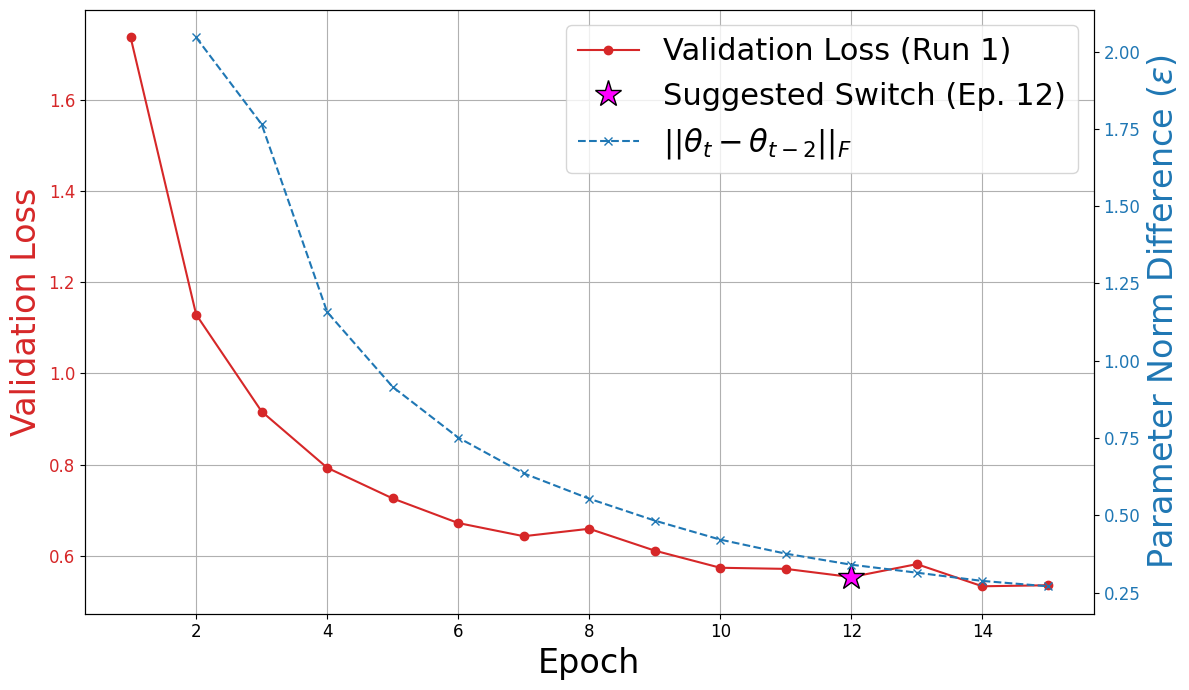

Plot saved as fashionmnist_sc_avg_acc_p_10_0.007_0.3767.png


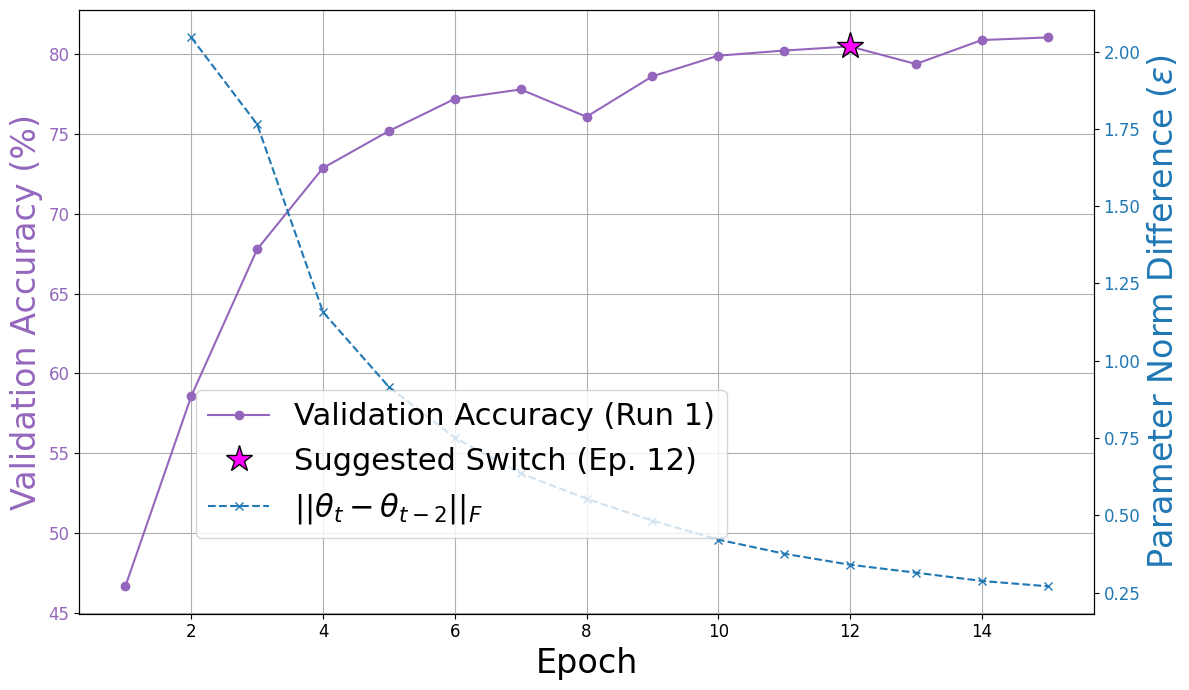

In [22]:
# --- DYNAMIC FILENAME GENERATION ---
dataset_prefix = f"{dataset_name.lower().replace('-', '')}_sc_avg"
network_width = layer_dims[1]
metric_char = 'n' if switch_config['method'] == 'ntk_norm' else 'p'
filename_template = f"{dataset_prefix}_{{metric_type}}_{metric_char}_{network_width}_{scouting_lr}_{recommended_threshold:.4f}.png"

# --- PLOTTING SETUP ---
# Define font sizes for better readability in a report
TITLE_FONT = 18
LABEL_FONT = 24
LEGEND_FONT = 22
TICK_FONT = 12

# --- PLOTTING (Using data from the FIRST run for visualization) ---
switch_idx = min(suggested_switch_epoch - 1, len(val_loss) - 1)
loss_at_switch = val_loss[switch_idx]
acc_at_switch = val_acc[switch_idx] * 100

if switch_config['method'] == 'param_norm':
    metric_label, linestyle, marker, color = r'Parameter Norm Difference ($\epsilon$)', '--', 'x', 'tab:blue'
    window_val, title_suffix = switch_config['param_norm_window'], 'Parameter Stability'
    legend_label = fr'$||\theta_t - \theta_{{t-{window_val}}}||_F$'
else: # ntk_norm
    metric_label, linestyle, marker, color = r'NTK Stability ($\delta$)', ':', 's', 'tab:green'
    window_val, title_suffix = switch_config['ntk_norm_window'], 'NTK Stability'
    legend_label = fr'| $||\Theta_t - \Theta_0||_F - ||\Theta_{{t-{window_val}}}-\Theta_0||_F$ |'

# PLOT 1: Validation Loss vs. Stability
fig1, ax1 = plt.subplots(1, 1, figsize=(12, 7))
ax1.plot(epochs, val_loss, color='tab:red', marker='o', label='Validation Loss (Run 1)', zorder=5)
ax1.plot(suggested_switch_epoch, loss_at_switch, '*', color='magenta', markersize=20, label=f'Suggested Switch (Ep. {suggested_switch_epoch})', zorder=10, markeredgecolor='black')
ax1.set_ylabel('Validation Loss', color='tab:red', fontsize=LABEL_FONT)
ax1.tick_params(axis='y', labelcolor='tab:red', labelsize=TICK_FONT)
ax1_twin = ax1.twinx()
ax1_twin.plot(epochs, norm_diff, color=color, marker=marker, linestyle=linestyle, label=legend_label)
ax1_twin.set_ylabel(metric_label, color=color, fontsize=LABEL_FONT)
ax1_twin.tick_params(axis='y', labelcolor=color, labelsize=TICK_FONT)
ax1.set_xlabel('Epoch', fontsize=LABEL_FONT)
ax1.tick_params(axis='x', labelsize=TICK_FONT)
ax1.grid(True)
fig1.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes, fontsize=LEGEND_FONT)
fig1.tight_layout()
val_filename = filename_template.format(metric_type='val')
plt.savefig(val_filename)
print(f"\nPlot saved as {val_filename}")
plt.show()

# PLOT 2: Accuracy vs. Stability
fig2, ax2 = plt.subplots(1, 1, figsize=(12, 7))
ax2.plot(epochs, val_acc * 100, color='tab:purple', marker='o', label='Validation Accuracy (Run 1)', zorder=5)
ax2.plot(suggested_switch_epoch, acc_at_switch, '*', color='magenta', markersize=20, label=f'Suggested Switch (Ep. {suggested_switch_epoch})', zorder=10, markeredgecolor='black')
ax2.set_ylabel('Validation Accuracy (%)', color='tab:purple', fontsize=LABEL_FONT)
ax2.tick_params(axis='y', labelcolor='tab:purple', labelsize=TICK_FONT)
ax2_twin = ax2.twinx()
ax2_twin.plot(epochs, norm_diff, color=color, marker=marker, linestyle=linestyle, label=legend_label)
ax2_twin.set_ylabel(metric_label, color=color, fontsize=LABEL_FONT)
ax2_twin.tick_params(axis='y', labelcolor=color, labelsize=TICK_FONT)
ax2.set_xlabel('Epoch', fontsize=LABEL_FONT)
ax2.tick_params(axis='x', labelsize=TICK_FONT)
ax2.grid(True)
# --- CORRECTED LINE ---
fig2.legend(loc="lower left", bbox_to_anchor=(0.1, 0.1), bbox_transform=ax2.transAxes, fontsize=LEGEND_FONT)
fig2.tight_layout()
acc_filename = filename_template.format(metric_type='acc')
plt.savefig(acc_filename)
print(f"Plot saved as {acc_filename}")
plt.show()

Run Main Experiment Loop:

In [28]:
all_runs_histories = {'SGD_Part1': [], 'SGD_Part2': [], 'NTK1_from_Switch': [], 'NTK2_from_Switch': [], 'NTK3_from_Switch': []}
all_runs_times = {'SGD (Part 1)': [], 'SGD (Part 2)': [], 'NTK1': [], 'NTK2': [], 'NTK3': []}
all_runs_test_metrics = {'Params_At_Switch': [], 'SGD_Full_Run': [], 'NTK1_from_Switch': [], 'NTK2_from_Switch': [], 'NTK3_from_Switch': []}
all_runs_switch_epochs = []

for seed in range(num_seeds):
    print(f"\n\n===== RUNNING EXPERIMENT FOR SEED {seed + 1}/{num_seeds} =====")
    key_init_params, key_sgd_part1, key_sgd_part2, key_ntk_subset_shuffle, key_ntk1, key_ntk2, key_ntk3 = run_keys[seed]
    initial_model_params = init_network_params(layer_dims, key_init_params)

    # --- CORRECTED: Create distinct subsets for monitoring and NTK training ---
    key_monitor_subset, key_train_subset = jax.random.split(key_ntk_subset_shuffle)

    # Subset for NTK stability monitoring during the first SGD phase
    X_ntk_monitor_subset = X_train_full
    if max_ntk_scouting_val is not None and max_ntk_scouting_val < X_train_full.shape[0]:
        monitor_indices = jax.random.choice(key_monitor_subset, X_train_full.shape[0], 
                                            shape=(max_ntk_scouting_val,), replace=False)
        X_ntk_monitor_subset = X_train_full[monitor_indices]

    # Subset for the actual NTK training phases (NTK1, NTK2, NTK3)
    X_train_ntk_subset, Y_train_onehot_ntk_subset = X_train_full, Y_train_onehot_full
    if max_ntk_samples_val is not None and max_ntk_samples_val < X_train_full.shape[0]:
        train_indices = jax.random.choice(key_train_subset, X_train_full.shape[0],
                                          shape=(max_ntk_samples_val,), replace=False)
        X_train_ntk_subset = X_train_full[train_indices]
        Y_train_onehot_ntk_subset = Y_train_onehot_full[train_indices]
    
    # --- Initial SGD Phase (up to switch point) ---
    params_at_switch, history_sgd_part1, time_sgd_part1, epoch_at_switch = run_sgd_monitoring_switch(
        initial_model_params, X_train_full, Y_train_onehot_full, X_val_full, Y_val_onehot_full,
        max_sgd_epochs=total_epochs,
        batch_size=min(batch_size_config, X_train_full.shape[0]),
        lr_sgd=lr_sgd_config, key_sgd_loop=key_sgd_part1,
        switch_config=switch_config,
        X_ntk_monitor_subset=X_ntk_monitor_subset, num_classes=num_classes
    )
    all_runs_switch_epochs.append(epoch_at_switch)
    all_runs_histories['SGD_Part1'].append(history_sgd_part1)
    all_runs_times['SGD (Part 1)'].append(time_sgd_part1)
    test_l_s, test_a_s = evaluate_on_test_jax(params_at_switch, X_test_full, Y_test_onehot_full)
    all_runs_test_metrics['Params_At_Switch'].append({'loss': test_l_s, 'acc': test_a_s})

    if epoch_at_switch >= total_epochs:
        print(f"WARNING: Switch condition not met for seed {seed+1}. Adjust thresholds or total epochs.")
        all_runs_histories['SGD_Part2'].append({'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []})
        all_runs_times['SGD (Part 2)'].append(0.0)
        all_runs_test_metrics['SGD_Full_Run'].append({'loss': test_l_s, 'acc': test_a_s})
        all_runs_test_metrics['NTK1_from_Switch'].append({'loss': np.nan, 'acc': np.nan})
        all_runs_test_metrics['NTK2_from_Switch'].append({'loss': np.nan, 'acc': np.nan})
        all_runs_test_metrics['NTK3_from_Switch'].append({'loss': np.nan, 'acc': np.nan})
        continue

    num_ntk_iterations_to_run = total_epochs - epoch_at_switch
    
    # --- Continued SGD Phase ---
    params_after_full_sgd, history_sgd_part2, time_sgd_part2 = run_sgd_epochs(
        copy.deepcopy(params_at_switch), X_train_full, Y_train_onehot_full, X_val_full, Y_val_onehot_full,
        start_epoch_idx=epoch_at_switch, num_epochs_to_run=num_ntk_iterations_to_run,
        batch_size=min(batch_size_config, X_train_full.shape[0]),
        lr_sgd=lr_sgd_config, key_sgd_loop=key_sgd_part2, phase_label="SGD (Part 2)"
    )
    all_runs_histories['SGD_Part2'].append(history_sgd_part2)
    all_runs_times['SGD (Part 2)'].append(time_sgd_part2)
    test_l_full, test_a_full = evaluate_on_test_jax(params_after_full_sgd, X_test_full, Y_test_onehot_full)
    all_runs_test_metrics['SGD_Full_Run'].append({'loss': test_l_full, 'acc': test_a_full})
    
    # --- NTK Phases ---
    current_ntk_batch_size = min(batch_size_config, X_train_ntk_subset.shape[0])
    if num_ntk_iterations_to_run > 0:
        params_after_ntk1, history_ntk1, time_ntk1 = run_ntk1_phase(
            copy.deepcopy(params_at_switch), X_train_ntk_subset, Y_train_onehot_ntk_subset,
            X_val_full, Y_val_onehot_full, num_ntk_iterations_to_run, 
            current_ntk_batch_size, lr_ntk_iterative_config, key_ntk1)
        all_runs_histories['NTK1_from_Switch'].append(history_ntk1)
        all_runs_times['NTK1'].append(time_ntk1)
        test_l_ntk1, test_a_ntk1 = evaluate_on_test_jax(params_after_ntk1, X_test_full, Y_test_onehot_full)
        all_runs_test_metrics['NTK1_from_Switch'].append({'loss': test_l_ntk1, 'acc': test_a_ntk1})

        params_after_ntk2, history_ntk2, time_ntk2 = run_ntk2_phase(
            copy.deepcopy(params_at_switch), X_train_ntk_subset, Y_train_onehot_ntk_subset,
            X_val_full, Y_val_onehot_full, epoch_at_switch, num_ntk_iterations_to_run,
            lr_ntk_iterative_config, taylor_order_ntk2=taylor_order)
        all_runs_histories['NTK2_from_Switch'].append(history_ntk2)
        all_runs_times['NTK2'].append(time_ntk2)
        test_l_ntk2, test_a_ntk2 = evaluate_on_test_jax(params_after_ntk2, X_test_full, Y_test_onehot_full)
        all_runs_test_metrics['NTK2_from_Switch'].append({'loss': test_l_ntk2, 'acc': test_a_ntk2})

    params_after_ntk3, history_ntk3, time_ntk3 = run_ntk3_phase(
        copy.deepcopy(params_at_switch), X_train_ntk_subset, Y_train_onehot_ntk_subset,
        X_val_full, Y_val_onehot_full,
        lr_ntk=lr_ntk_iterative_config,
        lambda_ntk3_reg=lambda_ntk3_config,
        T_factor_ntk3=total_epochs,
        taylor_order_ntk3=taylor_order)
    all_runs_histories['NTK3_from_Switch'].append(history_ntk3)
    all_runs_times['NTK3'].append(time_ntk3)
    test_l_ntk3, test_a_ntk3 = evaluate_on_test_jax(params_after_ntk3, X_test_full, Y_test_onehot_full)
    all_runs_test_metrics['NTK3_from_Switch'].append({'loss': test_l_ntk3, 'acc': test_a_ntk3})



===== RUNNING EXPERIMENT FOR SEED 1/10 =====

--- Starting SGD Phase (Monitoring for Switch using 'param_norm') ---
SGD (Monitoring) Epoch 1 - Train L: 1.7223, A: 45.27% | Val L: 1.7200, A: 45.61% (took 0.91s)
SGD (Monitoring) Epoch 2 - Train L: 1.3196, A: 55.81% | Val L: 1.3105, A: 55.71% | Param diff norm (k=2) = 1.906131 (took 0.83s)
SGD (Monitoring) Epoch 3 - Train L: 1.0420, A: 63.41% | Val L: 1.0296, A: 63.79% | Param diff norm (k=2) = 1.662663 (took 0.80s)
SGD (Monitoring) Epoch 4 - Train L: 0.8569, A: 69.98% | Val L: 0.8463, A: 70.15% | Param diff norm (k=2) = 1.404105 (took 0.79s)
SGD (Monitoring) Epoch 5 - Train L: 0.7686, A: 72.55% | Val L: 0.7622, A: 72.82% | Param diff norm (k=2) = 1.073683 (took 0.79s)
SGD (Monitoring) Epoch 6 - Train L: 0.7359, A: 74.52% | Val L: 0.7256, A: 74.64% | Param diff norm (k=2) = 0.804924 (took 0.74s)
SGD (Monitoring) Epoch 7 - Train L: 0.6770, A: 75.98% | Val L: 0.6735, A: 75.64% | Param diff norm (k=2) = 0.654852 (took 0.74s)
SGD (Monitorin

Average results:

In [29]:
avg_histories = {}
avg_histories['SGD_Part1'] = aggregate_histories(all_runs_histories['SGD_Part1'], metric_keys=['val_loss', 'val_acc'])
avg_histories['SGD_Part2'] = aggregate_histories(all_runs_histories['SGD_Part2'], metric_keys=['train_loss', 'train_acc', 'val_loss', 'val_acc'])
avg_histories['NTK1_from_Switch'] = aggregate_histories(all_runs_histories['NTK1_from_Switch'], metric_keys=['train_loss', 'train_acc', 'val_loss', 'val_acc'])
avg_histories['NTK2_from_Switch'] = aggregate_histories(all_runs_histories['NTK2_from_Switch'], metric_keys=['train_loss', 'train_acc', 'val_loss', 'val_acc'])

ntk3_final_train_losses = [h['train_loss'][0] for h in all_runs_histories['NTK3_from_Switch'] if h['train_loss']]
ntk3_final_val_losses   = [h['val_loss'][0] for h in all_runs_histories['NTK3_from_Switch'] if h['val_loss']]
ntk3_final_train_accs = [h['train_acc'][0] for h in all_runs_histories['NTK3_from_Switch'] if h['train_acc']]
ntk3_final_val_accs   = [h['val_acc'][0] for h in all_runs_histories['NTK3_from_Switch'] if h['val_acc']]

avg_histories['NTK3_from_Switch_Aggregated'] = {
    'train_loss': aggregate_scalar_metrics(ntk3_final_train_losses),
    'val_loss':   aggregate_scalar_metrics(ntk3_final_val_losses),
    'train_acc': aggregate_scalar_metrics(ntk3_final_train_accs),
    'val_acc':  aggregate_scalar_metrics(ntk3_final_val_accs)
}

avg_switch_epoch = np.mean(all_runs_switch_epochs)

avg_times = {phase: np.mean(times) for phase, times in all_runs_times.items() if times}
avg_test_metrics = {}
for phase, metrics_list in all_runs_test_metrics.items():
    if metrics_list:
        avg_test_metrics[phase] = {
            'loss_mean': np.nanmean([m.get('loss', np.nan) for m in metrics_list]),
            'loss_std':  np.nanstd([m.get('loss', np.nan) for m in metrics_list]),
            'acc_mean': np.nanmean([m.get('acc', np.nan) for m in metrics_list]),
            'acc_std':  np.nanstd([m.get('acc', np.nan) for m in metrics_list])
        }

Plot the results:


Loss plot saved as fashionmnist_tr_loss_p_10_0.007_0.3767.png


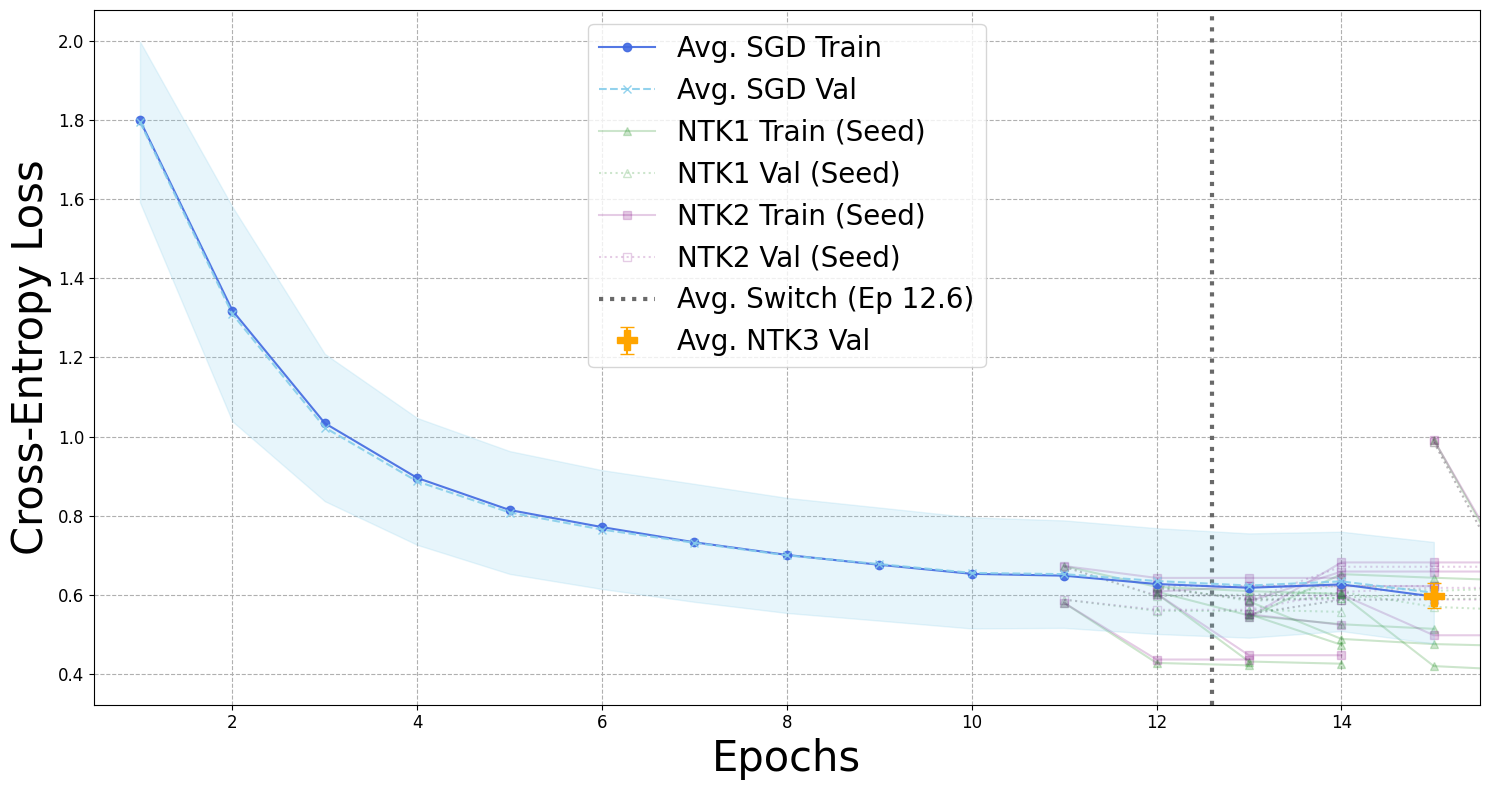

Accuracy plot saved as fashionmnist_tr_acc_p_10_0.007_0.3767.png


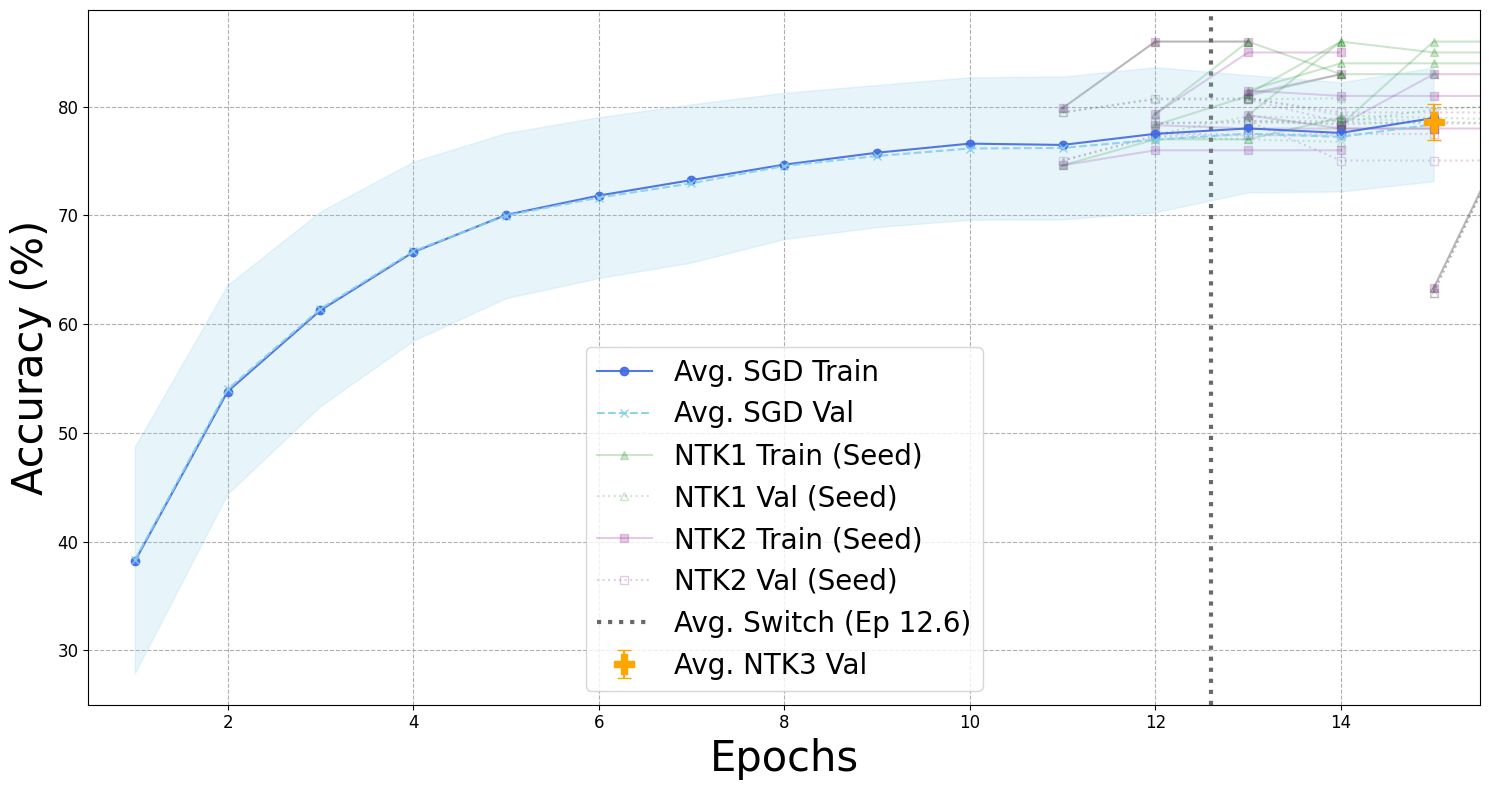

In [30]:
# --- DYNAMIC FILENAME GENERATION FOR MAIN EXPERIMENT ---
dataset_prefix = f"{dataset_name.lower().replace('-', '')}_tr"
network_width = layer_dims[1]
metric_char = 'n' if switch_config['method'] == 'ntk_norm' else 'p'
threshold = switch_config.get(f"{switch_config['method']}_threshold", 0.0) or 0.0
lr_val = lr_sgd_config
filename_template = f"{dataset_prefix}_{{metric_type}}_{metric_char}_{network_width}_{lr_val}_{threshold:.4f}.png"

# --- PLOTTING SETUP ---
# Define font sizes for better readability in a report
TITLE_FONT = 18
LABEL_FONT = 30
LEGEND_FONT = 20
TICK_FONT = 12

# --- PLOT 1: LOSS TRAJECTORIES ---
fig1, ax1 = plt.subplots(1, 1, figsize=(15, 8))

# --- Create full SGD trajectories for each run, then aggregate. ---
full_sgd_histories = []
metric_keys_to_agg = ['train_loss', 'val_loss', 'train_acc', 'val_acc']
for h1, h2 in zip(all_runs_histories['SGD_Part1'], all_runs_histories['SGD_Part2']):
    full_history = {}
    for key in metric_keys_to_agg:
        full_history[key] = h1.get(key, []) + h2.get(key, [])
    full_sgd_histories.append(full_history)

avg_sgd_full = aggregate_histories(full_sgd_histories, metric_keys=metric_keys_to_agg)

# Plot averaged full SGD trajectory
num_full_epochs = len(avg_sgd_full['val_loss']['mean'])
epochs_x_full_sgd = np.arange(1, num_full_epochs + 1)

if epochs_x_full_sgd.size > 0:
    ax1.plot(epochs_x_full_sgd, avg_sgd_full['train_loss']['mean'], label='Avg. SGD Train', marker='o', linestyle='-', color='royalblue', alpha=0.9, zorder=10)
    ax1.plot(epochs_x_full_sgd, avg_sgd_full['val_loss']['mean'], label='Avg. SGD Val', marker='x', linestyle='--', color='skyblue', alpha=0.9, zorder=10)
    ax1.fill_between(epochs_x_full_sgd,
                     np.array(avg_sgd_full['val_loss']['mean']) - np.array(avg_sgd_full['val_loss']['std']),
                     np.array(avg_sgd_full['val_loss']['mean']) + np.array(avg_sgd_full['val_loss']['std']),
                     color='skyblue', alpha=0.2, zorder=5)

# Plot Individual NTK Trajectories (semi-transparent)
for i in range(num_seeds):
    switch_epoch = all_runs_switch_epochs[i]
    start_point_index = switch_epoch - 1

    if start_point_index < len(all_runs_histories['SGD_Part1'][i]['val_loss']):
        start_tl = all_runs_histories['SGD_Part1'][i]['train_loss'][start_point_index]
        start_vl = all_runs_histories['SGD_Part1'][i]['val_loss'][start_point_index]

        for ntk_key, color, marker_style in [('NTK1_from_Switch', 'green', '^'), ('NTK2_from_Switch', 'purple', 's')]:
             if i < len(all_runs_histories[ntk_key]):
                ntk_hist = all_runs_histories[ntk_key][i]
                ntk_len = len(ntk_hist['val_loss'])
                if ntk_len > 0:
                    epochs_x_ntk = np.arange(switch_epoch + 1, switch_epoch + 1 + ntk_len)
                    x_branch = np.insert(epochs_x_ntk, 0, switch_epoch)
                    tl_branch = [start_tl] + ntk_hist['train_loss']
                    vl_branch = [start_vl] + ntk_hist['val_loss']
                    label_prefix = ntk_key.split('_')[0]
                    ax1.plot(x_branch, tl_branch, marker=marker_style, linestyle='-', color=color, alpha=0.2, label=f'{label_prefix} Train (Seed)' if i == 0 else None)
                    ax1.plot(x_branch, vl_branch, marker=marker_style, linestyle=':', color=color, alpha=0.2, label=f'{label_prefix} Val (Seed)' if i == 0 else None, mfc='none')

# Plot NTK3 (One-Shot)
avg_ntk3_loss = avg_histories['NTK3_from_Switch_Aggregated']['val_loss']
ax1.errorbar(total_epochs, avg_ntk3_loss['mean'], yerr=avg_ntk3_loss['std'], fmt='P', markersize=15, color='orange', label='Avg. NTK3 Val', zorder=11, capsize=5)

# Plot Average Switch Point
avg_switch_epoch_plot = np.mean(all_runs_switch_epochs)
ax1.axvline(x=avg_switch_epoch_plot, color='dimgray', linestyle=':', linewidth=3, label=f'Avg. Switch (Ep {avg_switch_epoch_plot:.1f})')

# Final Touches for Loss Plot
ax1.set_ylabel("Cross-Entropy Loss", fontsize=LABEL_FONT)
ax1.set_xlabel("Epochs", fontsize=LABEL_FONT)
ax1.legend(fontsize=LEGEND_FONT, loc='best')
ax1.grid(True, which='both', linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=TICK_FONT)
ax1.set_xlim(left=0.5, right=total_epochs + 0.5)
fig1.tight_layout()
loss_filename = filename_template.format(metric_type='loss')
plt.savefig(loss_filename)
print(f"\nLoss plot saved as {loss_filename}")
plt.show()


# --- PLOT 2: ACCURACY TRAJECTORIES ---
fig2, ax2 = plt.subplots(1, 1, figsize=(15, 8))

# Plot averaged full SGD trajectory for Accuracy
if epochs_x_full_sgd.size > 0:
    ax2.plot(epochs_x_full_sgd, np.array(avg_sgd_full['train_acc']['mean'])*100, label='Avg. SGD Train', marker='o', linestyle='-', color='royalblue', alpha=0.9, zorder=10)
    ax2.plot(epochs_x_full_sgd, np.array(avg_sgd_full['val_acc']['mean'])*100, label='Avg. SGD Val', marker='x', linestyle='--', color='skyblue', alpha=0.9, zorder=10)
    ax2.fill_between(epochs_x_full_sgd,
                     (np.array(avg_sgd_full['val_acc']['mean']) - np.array(avg_sgd_full['val_acc']['std']))*100,
                     (np.array(avg_sgd_full['val_acc']['mean']) + np.array(avg_sgd_full['val_acc']['std']))*100,
                     color='skyblue', alpha=0.2, zorder=5)

# Plot Individual NTK Trajectories for Accuracy
for i in range(num_seeds):
    switch_epoch = all_runs_switch_epochs[i]
    start_point_index = switch_epoch - 1

    if start_point_index < len(all_runs_histories['SGD_Part1'][i]['val_acc']):
        start_tacc = all_runs_histories['SGD_Part1'][i]['train_acc'][start_point_index]
        start_vacc = all_runs_histories['SGD_Part1'][i]['val_acc'][start_point_index]

        for ntk_key, color, marker_style in [('NTK1_from_Switch', 'green', '^'), ('NTK2_from_Switch', 'purple', 's')]:
            if i < len(all_runs_histories[ntk_key]):
                ntk_hist = all_runs_histories[ntk_key][i]
                ntk_len = len(ntk_hist['val_acc'])
                if ntk_len > 0:
                    epochs_x_ntk = np.arange(switch_epoch + 1, switch_epoch + 1 + ntk_len)
                    x_branch = np.insert(epochs_x_ntk, 0, switch_epoch)
                    tacc_branch = np.array([start_tacc] + ntk_hist['train_acc']) * 100
                    vacc_branch = np.array([start_vacc] + ntk_hist['val_acc']) * 100
                    label_prefix = ntk_key.split('_')[0]
                    ax2.plot(x_branch, tacc_branch, marker=marker_style, linestyle='-', color=color, alpha=0.2, label=f'{label_prefix} Train (Seed)' if i == 0 else None)
                    ax2.plot(x_branch, vacc_branch, marker=marker_style, linestyle=':', color=color, alpha=0.2, label=f'{label_prefix} Val (Seed)' if i == 0 else None, mfc='none')

# Plot NTK3 (One-Shot) for Accuracy
avg_ntk3_acc = avg_histories['NTK3_from_Switch_Aggregated']['val_acc']
ax2.errorbar(total_epochs, avg_ntk3_acc['mean']*100, yerr=avg_ntk3_acc['std']*100, fmt='P', markersize=15, color='orange', label='Avg. NTK3 Val', zorder=11, capsize=5)

# Plot Average Switch Point
ax2.axvline(x=avg_switch_epoch_plot, color='dimgray', linestyle=':', linewidth=3, label=f'Avg. Switch (Ep {avg_switch_epoch_plot:.1f})')

# Final Touches for Accuracy Plot
ax2.set_ylabel("Accuracy (%)", fontsize=LABEL_FONT)
ax2.set_xlabel("Epochs", fontsize=LABEL_FONT)
ax2.legend(fontsize=LEGEND_FONT, loc='best')
ax2.grid(True, which='both', linestyle='--')
ax2.tick_params(axis='both', which='major', labelsize=TICK_FONT)
ax2.set_xlim(left=0.5, right=total_epochs + 0.5)
fig2.tight_layout()
acc_filename = filename_template.format(metric_type='acc')
plt.savefig(acc_filename)
print(f"Accuracy plot saved as {acc_filename}")
plt.show()

Summarize the results:

In [31]:
print("\n--- Averaged Final Test Metrics & Runtimes (across {} seeds) ---".format(num_seeds))
print(f"Switch Method: {switch_config['method']}")
print(f"Average Switch Epoch: {avg_switch_epoch:.2f} ± {np.std(all_runs_switch_epochs):.2f}")
print(f"\nSGD Part 1 (Monitoring Phase): Avg. Time: {avg_times.get('SGD (Part 1)',0.0):.2f}s")
if 'Params_At_Switch' in avg_test_metrics:
    m = avg_test_metrics['Params_At_Switch']
    print(f"  Params at Switch Point Test: Avg. Loss: {m['loss_mean']:.4f} ± {m['loss_std']:.4f}, Avg. Acc: {m['acc_mean']*100:.2f}% ± {m['acc_std']*100:.2f}%")

print(f"SGD Part 2 (Post-Switch Phase): Avg. Time: {avg_times.get('SGD (Part 2)',0.0):.2f}s")

if 'SGD_Full_Run' in avg_test_metrics:
    m = avg_test_metrics['SGD_Full_Run']
    total_avg_sgd_time = avg_times.get('SGD (Part 1)', 0.0) + avg_times.get('SGD (Part 2)', 0.0)
    print(f"SGD Full Run ({total_epochs} total epochs): Avg. Total Time: {total_avg_sgd_time:.2f}s")
    print(f"  Test: Avg. Loss: {m['loss_mean']:.4f} ± {m['loss_std']:.4f}, Avg. Acc: {m['acc_mean']*100:.2f}% ± {m['acc_std']*100:.2f}%")

print("") # Add a blank line for readability

for phase_key_suffix in ['NTK1', 'NTK2', 'NTK3']:
    full_phase_key = f'{phase_key_suffix}_from_Switch'
    if full_phase_key in avg_test_metrics:
        m = avg_test_metrics[full_phase_key]
        avg_time = avg_times.get(phase_key_suffix, 0.0)
        print(f"Phase: {phase_key_suffix:<5} (from switch) | Avg. Test Loss: {m['loss_mean']:.4f} ± {m['loss_std']:.4f}, Avg. Test Acc: {m['acc_mean']*100:.2f}% ± {m['acc_std']*100:.2f}% | Avg. Time: {avg_time:.2f}s")


--- Averaged Final Test Metrics & Runtimes (across 10 seeds) ---
Switch Method: param_norm
Average Switch Epoch: 12.60 ± 1.20

SGD Part 1 (Monitoring Phase): Avg. Time: 13.21s
  Params at Switch Point Test: Avg. Loss: 0.6479 ± 0.1204, Avg. Acc: 76.49% ± 4.84%
SGD Part 2 (Post-Switch Phase): Avg. Time: 2.09s
SGD Full Run (15 total epochs): Avg. Total Time: 15.30s
  Test: Avg. Loss: 0.6121 ± 0.1290, Avg. Acc: 78.14% ± 5.09%

Phase: NTK1  (from switch) | Avg. Test Loss: 0.5910 ± 0.0247, Avg. Test Acc: 78.96% ± 1.33% | Avg. Time: 0.37s
Phase: NTK2  (from switch) | Avg. Test Loss: 0.6093 ± 0.0349, Avg. Test Acc: 77.99% ± 1.89% | Avg. Time: 0.11s
Phase: NTK3  (from switch) | Avg. Test Loss: 0.6059 ± 0.0331, Avg. Test Acc: 78.07% ± 1.90% | Avg. Time: 0.36s
